## CS310 Natural Language Processing
## Assignment 1. Neural Text Classification

**Total points**: 50

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from Lab 2. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support

### 1. Data Processing

In [3]:


class BasicTokenizer:
    def __init__(self):
        pass
    
    def tokenize(self, text):
        chinese_chars = re.findall(r'[\u4e00-\u9fff]', text)
        return chinese_chars

# 改进的分词器
class ImprovedTokenizer:
    def __init__(self):
        pass
    
    def tokenize(self, text):
        tokens = []
        pattern = r'[\u4e00-\u9fff]|[0-9]+|[a-zA-Z]+|[^\w\s]'
        matches = re.finditer(pattern, text)
        for match in matches:
            tokens.append(match.group(0))
        return tokens


class HumorDataset(Dataset):
    def __init__(self, file_path, tokenizer, vocab=None, max_len=100):
        self.data = []
        self.labels = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        
   
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                item = json.loads(line)
                tokens = self.tokenizer.tokenize(item['sentence'])
                self.data.append(tokens)
                self.labels.append(item['label'][0])

        if vocab is None:
            self.vocab = {'<PAD>': 0, '<UNK>': 1}
            token_counter = Counter()
            for tokens in self.data:
                token_counter.update(tokens)

            for token, count in token_counter.items():
                if count > 1:
                    self.vocab[token] = len(self.vocab)
        else:
            self.vocab = vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tokens = self.data[idx]
        label = self.labels[idx]
        

        indices = []
        for token in tokens[:self.max_len]:
            if token in self.vocab:
                indices.append(self.vocab[token])
            else:
                indices.append(self.vocab['<UNK>'])
        

        if len(indices) < self.max_len:
            indices += [self.vocab['<PAD>']] * (self.max_len - len(indices))
        
        return {
            'input_ids': torch.tensor(indices, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }
    
    def get_vocab(self):
        return self.vocab


def load_data(train_path, test_path, tokenizer_type='improved', batch_size=32):
    if tokenizer_type == 'basic':
        tokenizer = BasicTokenizer()
    else:
        tokenizer = ImprovedTokenizer()

    train_dataset = HumorDataset(train_path, tokenizer)
    vocab = train_dataset.get_vocab()

    test_dataset = HumorDataset(test_path, tokenizer, vocab=vocab)
    

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader, vocab

### 2. Build the Model

In [4]:

class HumorClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dims=[256, 128], num_classes=2):
        super(HumorClassifier, self).__init__()
        

        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, mode='mean')
        

        layers = []
        input_dim = embed_dim
        

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))  
            input_dim = hidden_dim
        

        layers.append(nn.Linear(input_dim, num_classes))
        

        self.fc_layers = nn.Sequential(*layers)
        

        self.init_weights()
    
    def init_weights(self):

        nn.init.xavier_uniform_(self.embedding.weight)
        

        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, text, offsets=None):

        if offsets is None:

            batch_size = text.size(0)
            offsets = torch.arange(0, batch_size, dtype=torch.long, device=text.device) * text.size(1)

        embedded = self.embedding(text.view(-1), offsets)

        output = self.fc_layers(embedded)
        
        return output

### 3. Train and Evaluate

使用设备: cpu


/Users/sco/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/90, Loss: 0.6030, Train Acc: 0.7123, Test Acc: 0.7389
Precision: 0.5459, Recall: 0.7389, F1: 0.6279
Epoch 2/90, Loss: 0.5735, Train Acc: 0.7144, Test Acc: 0.7327
Precision: 0.6536, Recall: 0.7327, F1: 0.6452
Epoch 3/90, Loss: 0.5383, Train Acc: 0.7398, Test Acc: 0.7235
Precision: 0.6985, Recall: 0.7235, F1: 0.7065
Epoch 4/90, Loss: 0.5174, Train Acc: 0.7513, Test Acc: 0.7435
Precision: 0.7121, Recall: 0.7435, F1: 0.7154
Epoch 5/90, Loss: 0.5043, Train Acc: 0.7642, Test Acc: 0.7419
Precision: 0.7132, Recall: 0.7419, F1: 0.7182
Epoch 6/90, Loss: 0.4926, Train Acc: 0.7723, Test Acc: 0.7435
Precision: 0.7108, Recall: 0.7435, F1: 0.7133
Epoch 7/90, Loss: 0.4770, Train Acc: 0.7784, Test Acc: 0.7465
Precision: 0.7156, Recall: 0.7465, F1: 0.7178
Epoch 8/90, Loss: 0.4625, Train Acc: 0.7871, Test Acc: 0.7481
Precision: 0.7164, Recall: 0.7481, F1: 0.7169
Epoch 9/90, Loss: 0.4506, Train Acc: 0.7942, Test Acc: 0.7250
Precision: 0.6912, Recall: 0.7250, F1: 0.6992
Epoch 10/90, Loss: 0.4466, T

/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipyker

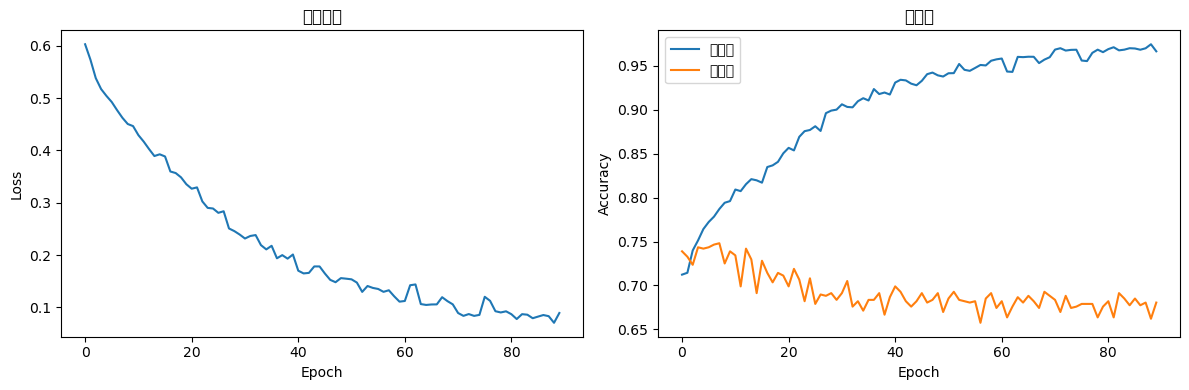


最终测试结果:
准确率: 0.6805
精确率: 0.6841
召回率: 0.6805
F1分数: 0.6823


In [10]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):

    model = model.to(device)
    

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:

            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            
            optimizer.zero_grad()
            
           
            outputs = model(inputs)
            
            
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer.step()
            
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
       
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        
        test_acc, test_metrics = evaluate_model(model, test_loader, device)
        test_accs.append(test_acc)
        
       
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Precision: {test_metrics["precision"]:.4f}, Recall: {test_metrics["recall"]:.4f}, F1: {test_metrics["f1"]:.4f}')
    

    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'test_acc': test_accs
    }
    
    return history, test_metrics

def evaluate_model(model, data_loader, device='cpu'):
    model.eval()
    total_correct = 0
    total_count = 0
    y_labels = []
    y_preds = []
    
    with torch.no_grad():
        for batch in data_loader:
            
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            
            outputs = model(inputs)
            
            
            predictions = outputs.argmax(1)
            
            
            total_correct += (predictions == labels).sum().item()
            total_count += labels.size(0)
            

            y_labels.extend(labels.cpu().numpy())
            y_preds.extend(predictions.cpu().numpy())
    

    accuracy = total_correct / total_count
    

    precision, recall, f1, _ = precision_recall_fscore_support(y_labels, y_preds, average='weighted')
    
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return accuracy, metrics

def calculate_metrics(y_true, y_pred):

    tp = sum((y_pred == 1) & (np.array(y_true) == 1))
    fp = sum((y_pred == 1) & (np.array(y_true) == 0))
    tn = sum((y_pred == 0) & (np.array(y_true) == 0))
    fn = sum((y_pred == 0) & (np.array(y_true) == 1))
    
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.title('训练损失')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='训练集')
    plt.plot(history['test_acc'], label='测试集')
    plt.title('准确率')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def run_experiment(train_path, test_path, tokenizer_type='improved', batch_size=256, 
                  embed_dim=128, hidden_dims=[256, 128], epochs=90, lr=0.003):
    # 加载数据
    train_loader, test_loader, vocab = load_data(train_path, test_path, tokenizer_type, batch_size)
    
    # 创建模型
    vocab_size = len(vocab)
    model = HumorClassifier(vocab_size, embed_dim, hidden_dims)
    

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # 训练模型
    history, final_metrics = train_model(model, train_loader, test_loader, epochs, lr, device)
    

    plot_training_history(history)
    
    # 打印最终结果
    print("\n最终测试结果:")
    print(f"准确率: {history['test_acc'][-1]:.4f}")
    print(f"精确率: {final_metrics['precision']:.4f}")
    print(f"召回率: {final_metrics['recall']:.4f}")
    print(f"F1分数: {final_metrics['f1']:.4f}")
    
    return model, history, final_metrics

model, history, metrics = run_experiment('train.jsonl', 'test.jsonl')

### 4. Explore Word Segmentation

使用基本字符级分词器...
使用设备: cpu


/Users/sco/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/90, Loss: 0.6077, Train Acc: 0.7085, Test Acc: 0.7389
Precision: 0.5459, Recall: 0.7389, F1: 0.6279
Epoch 2/90, Loss: 0.5774, Train Acc: 0.7159, Test Acc: 0.7496
Precision: 0.7137, Recall: 0.7496, F1: 0.6975
Epoch 3/90, Loss: 0.5436, Train Acc: 0.7351, Test Acc: 0.7573
Precision: 0.7280, Recall: 0.7573, F1: 0.7117
Epoch 4/90, Loss: 0.5203, Train Acc: 0.7523, Test Acc: 0.7389
Precision: 0.7048, Recall: 0.7389, F1: 0.7087
Epoch 5/90, Loss: 0.5064, Train Acc: 0.7581, Test Acc: 0.7419
Precision: 0.7045, Recall: 0.7419, F1: 0.7041
Epoch 6/90, Loss: 0.4954, Train Acc: 0.7708, Test Acc: 0.6866
Precision: 0.6914, Recall: 0.6866, F1: 0.6889
Epoch 7/90, Loss: 0.4790, Train Acc: 0.7764, Test Acc: 0.7081
Precision: 0.6863, Recall: 0.7081, F1: 0.6945
Epoch 8/90, Loss: 0.4664, Train Acc: 0.7793, Test Acc: 0.7389
Precision: 0.6862, Recall: 0.7389, F1: 0.6680
Epoch 9/90, Loss: 0.4658, Train Acc: 0.7857, Test Acc: 0.7296
Precision: 0.7066, Recall: 0.7296, F1: 0.7139
Epoch 10/90, Loss: 0.4404, T

/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipyker

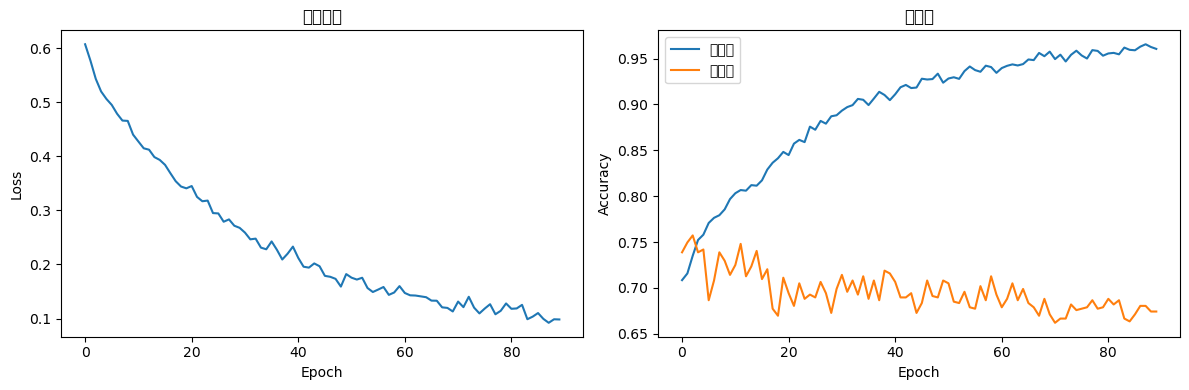


最终测试结果:
准确率: 0.6743
精确率: 0.6768
召回率: 0.6743
F1分数: 0.6756

使用改进的分词器...
使用设备: cpu


/Users/sco/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/90, Loss: 0.6058, Train Acc: 0.7041, Test Acc: 0.7389
Precision: 0.5459, Recall: 0.7389, F1: 0.6279
Epoch 2/90, Loss: 0.5770, Train Acc: 0.7159, Test Acc: 0.7404
Precision: 0.6892, Recall: 0.7404, F1: 0.6543
Epoch 3/90, Loss: 0.5418, Train Acc: 0.7373, Test Acc: 0.7281
Precision: 0.7090, Recall: 0.7281, F1: 0.7158
Epoch 4/90, Loss: 0.5182, Train Acc: 0.7533, Test Acc: 0.7358
Precision: 0.6998, Recall: 0.7358, F1: 0.7042
Epoch 5/90, Loss: 0.5030, Train Acc: 0.7605, Test Acc: 0.7220
Precision: 0.6943, Recall: 0.7220, F1: 0.7027
Epoch 6/90, Loss: 0.4848, Train Acc: 0.7711, Test Acc: 0.7158
Precision: 0.6943, Recall: 0.7158, F1: 0.7021
Epoch 7/90, Loss: 0.4791, Train Acc: 0.7743, Test Acc: 0.7496
Precision: 0.7198, Recall: 0.7496, F1: 0.7212
Epoch 8/90, Loss: 0.4564, Train Acc: 0.7917, Test Acc: 0.6851
Precision: 0.6977, Recall: 0.6851, F1: 0.6907
Epoch 9/90, Loss: 0.4367, Train Acc: 0.7955, Test Acc: 0.7112
Precision: 0.7047, Recall: 0.7112, F1: 0.7077
Epoch 10/90, Loss: 0.4348, T

/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/1407472014.py:150: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipyker

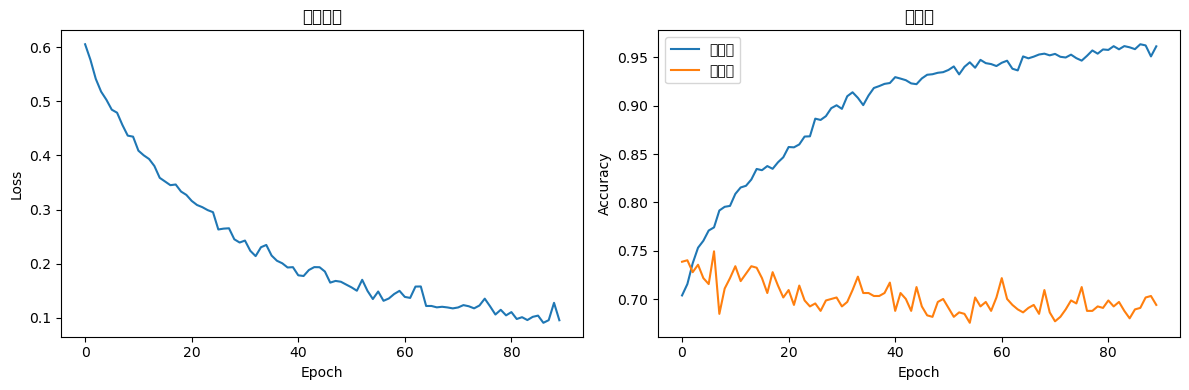


最终测试结果:
准确率: 0.6943
精确率: 0.7078
召回率: 0.6943
F1分数: 0.7003

使用jieba分词器...
使用设备: cpu
词汇表大小: 6019


/Users/sco/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/90, Loss: 0.6008, Train Acc: 0.7113, Test Acc: 0.7389
Precision: 0.5459, Recall: 0.7389, F1: 0.6279
Epoch 2/90, Loss: 0.5591, Train Acc: 0.7201, Test Acc: 0.7204
Precision: 0.6879, Recall: 0.7204, F1: 0.6967
Epoch 3/90, Loss: 0.4924, Train Acc: 0.7621, Test Acc: 0.6805
Precision: 0.6878, Recall: 0.6805, F1: 0.6839
Epoch 4/90, Loss: 0.4409, Train Acc: 0.7970, Test Acc: 0.7266
Precision: 0.6788, Recall: 0.7266, F1: 0.6839
Epoch 5/90, Loss: 0.3984, Train Acc: 0.8246, Test Acc: 0.6605
Precision: 0.6867, Recall: 0.6605, F1: 0.6712
Epoch 6/90, Loss: 0.3700, Train Acc: 0.8410, Test Acc: 0.6452
Precision: 0.6841, Recall: 0.6452, F1: 0.6598
Epoch 7/90, Loss: 0.3615, Train Acc: 0.8467, Test Acc: 0.7035
Precision: 0.6918, Recall: 0.7035, F1: 0.6969
Epoch 8/90, Loss: 0.3381, Train Acc: 0.8570, Test Acc: 0.6790
Precision: 0.6832, Recall: 0.6790, F1: 0.6810
Epoch 9/90, Loss: 0.3001, Train Acc: 0.8728, Test Acc: 0.6912
Precision: 0.6813, Recall: 0.6912, F1: 0.6858
Epoch 10/90, Loss: 0.2963, T

/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/3883482208.py:117: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/3883482208.py:117: UserWarning: Glyph 31526 (\N{CJK UNIFIED IDEOGRAPH-7B26}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/3883482208.py:117: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/3883482208.py:117: UserWarning: Glyph 25913 (\N{CJK UNIFIED IDEOGRAPH-6539}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_9161/3883482208.py:117: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipyker

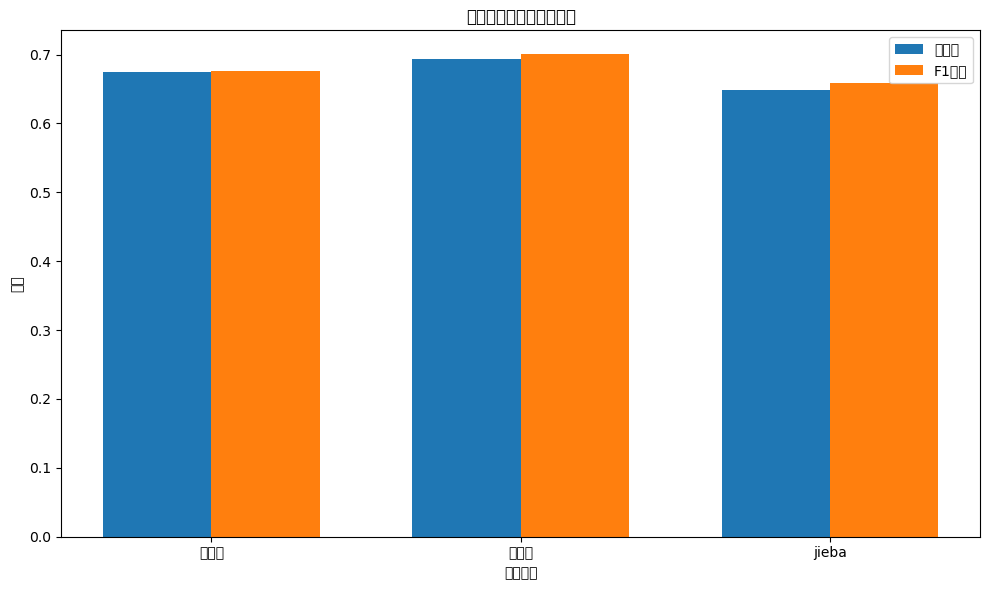

In [11]:
import jieba

# 使用jieba分词器的分词器
class JiebaTokenizer:
    def __init__(self):
        pass
    
    def tokenize(self, text):

        words = jieba.cut(text, cut_all=False)
        return list(words)

# 比较不同分词方法的性能
def compare_tokenizers(train_path, test_path, batch_size=256, embed_dim=128, 
                       hidden_dims=[128, 64], epochs=90, lr=0.005):
    results = {}
    

    print("使用基本字符级分词器...")
    model_char, history_char, metrics_char = run_experiment(
        train_path, test_path, tokenizer_type='basic', 
        batch_size=batch_size, embed_dim=embed_dim, 
        hidden_dims=hidden_dims, epochs=epochs, lr=lr
    )
    results['字符级'] = {
        'accuracy': history_char['test_acc'][-1],
        'precision': metrics_char['precision'],
        'recall': metrics_char['recall'],
        'f1': metrics_char['f1'],
        'vocab_size': len(model_char.embedding.weight)
    }
    

    print("\n使用改进的分词器...")
    model_improved, history_improved, metrics_improved = run_experiment(
        train_path, test_path, tokenizer_type='improved', 
        batch_size=batch_size, embed_dim=embed_dim, 
        hidden_dims=hidden_dims, epochs=epochs, lr=lr
    )
    results['改进的'] = {
        'accuracy': history_improved['test_acc'][-1],
        'precision': metrics_improved['precision'],
        'recall': metrics_improved['recall'],
        'f1': metrics_improved['f1'],
        'vocab_size': len(model_improved.embedding.weight)
    }
    

    print("\n使用jieba分词器...")

    def load_data_jieba(train_path, test_path, batch_size=32):
        tokenizer = JiebaTokenizer()
        

        train_dataset = HumorDataset(train_path, tokenizer)
        vocab = train_dataset.get_vocab()
        

        test_dataset = HumorDataset(test_path, tokenizer, vocab=vocab)
        

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
        return train_loader, test_loader, vocab
    

    train_loader, test_loader, vocab = load_data_jieba(train_path, test_path, batch_size)


    vocab_size = len(vocab)
    model = HumorClassifier(vocab_size, embed_dim, hidden_dims)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    print(f"词汇表大小: {vocab_size}")

    history_jieba, metrics_jieba = train_model(
        model, train_loader, test_loader, epochs, lr, device
    )
        
    results['jieba'] = {
        'accuracy': history_jieba['test_acc'][-1],
        'precision': metrics_jieba['precision'],
        'recall': metrics_jieba['recall'],
        'f1': metrics_jieba['f1'],
        'vocab_size': vocab_size
    }

    print("\n分词方法比较结果:")
    print(f"{'分词方法':<10} {'词汇表大小':<10} {'准确率':<10} {'精确率':<10} {'召回率':<10} {'F1分数':<10}")
    print("-" * 60)
    for method, metrics in results.items():
        print(f"{method:<10} {metrics['vocab_size']:<10} {metrics['accuracy']:.4f}     {metrics['precision']:.4f}     {metrics['recall']:.4f}     {metrics['f1']:.4f}")
    

    plt.figure(figsize=(10, 6))
    methods = list(results.keys())
    accuracies = [results[m]['accuracy'] for m in methods]
    f1_scores = [results[m]['f1'] for m in methods]
    
    x = np.arange(len(methods))
    width = 0.35
    
    plt.bar(x - width/2, accuracies, width, label='准确率')
    plt.bar(x + width/2, f1_scores, width, label='F1分数')
    
    plt.xlabel('分词方法')
    plt.ylabel('分数')
    plt.title('不同分词方法的性能比较')
    plt.xticks(x, methods)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results

# 运行比较实验
results = compare_tokenizers('train.jsonl', 'test.jsonl')